In [1]:
!pip install segmentation_models
!pip install keras==2.3.1
!pip install tensorflow==2.0.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
!pip install h5py==2.10.0

!pip install opencv-python
!pip install opencv-contrib-python

!pip install -q git+https://github.com/tensorflow/examples.git

     |████████████████████████████████| 50 kB 5.0 MB/s 
     |████████████████████████████████| 377 kB 4.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.3.1 which is incompatible.
     |████████████████████████████████| 86.3 MB 20 kB/s 
     |████████████████████████████████| 3.8 MB 40.7 MB/s 
     |████████████████████████████████| 449 kB 39.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=367cd0634023765e55aed4ca9265b18ccf743114b8ab5c15edc1e3cacca02b88
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tenso

In [12]:
import os
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

#import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
from segmentation_models.metrics import f1_score, iou_score
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
im_array_training = []
mask_array_training = []

def loadDataset(fold = 'fold1', shape = (256, 256)):
    im = []
    mask = []
    path_masks = f'./scratch/{fold}/masks'#f'./drive/MyDrive/data/scratch/{fold}/masks'
    path_ims = './scratch/images'#'./drive/MyDrive/data/scratch/images'

    names = list(map(lambda x: x.replace('.gif', ''), os.listdir(f'{path_masks}/left lung/')))


    for name in names:
        left = io.imread(f'{path_masks}/left lung/{name}.gif', as_gray=True)
        right = io.imread(f'{path_masks}/right lung/{name}.gif', as_gray=True)

        mask.append(resize(left+right, shape))

        im.append(resize(io.imread(f'{path_ims}/{name}.bmp', as_gray=True), shape))
    return np.array(im), np.array(mask)


im_array_training, mask_array_training  = loadDataset('fold1', (256,256))
im_array_testing, mask_array_testing  = loadDataset('fold2', (256,256))

In [3]:
# Validation split
im_array_training, im_array_val, mask_array_training, mask_array_val = train_test_split(im_array_training,mask_array_training,test_size=0.2)

In [4]:
# segmentation_models.Unet needs 3 color channels, this simply extends the
#   greyscale image to all three channels
im_array_training = im_array_training[:,:,:,np.newaxis]
im_array_val = im_array_val[:,:,:,np.newaxis]

print(im_array_training.shape)
add_layer = im_array_training
print(add_layer.shape)
im_array_training = np.concatenate([im_array_training, add_layer], axis=3)
im_array_training = np.concatenate([im_array_training, add_layer], axis=3)
print(im_array_training.shape)

print(im_array_training[0,50,50,0])
print(im_array_training[0,50,50,1])
print(im_array_training[0,50,50,2])

print(im_array_val.shape)
add_layer = im_array_val
print(add_layer.shape)
im_array_val = np.concatenate([im_array_val, add_layer], axis=3)
im_array_val = np.concatenate([im_array_val, add_layer], axis=3)
print(im_array_val.shape)

print(im_array_training[0,50,50,0])
print(im_array_training[0,50,50,1])
print(im_array_training[0,50,50,2])

mask_array_training = mask_array_training[:,:,:,np.newaxis]
mask_array_val = mask_array_val[:,:,:,np.newaxis]

(99, 256, 256, 1)
(99, 256, 256, 1)
(99, 256, 256, 3)
0.6156862745098044
0.6156862745098044
0.6156862745098044
(25, 256, 256, 1)
(25, 256, 256, 1)
(25, 256, 256, 3)
0.6156862745098044
0.6156862745098044
0.6156862745098044


In [13]:
model = sm.Unet( 
    #'resnet18',
    classes=1,
    activation='sigmoid',
    #encoder_weights='imagenet',
    input_shape=(256,256,3)
    #decoder_block_type='transpose'
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=sm.losses.dice_loss, #sm.losses.BinaryCELoss(),
    metrics=[f1_score]
)

In [ ]:
EPOCHS = 100 #113
BATCH_SIZE = 10
TRAINSET_SIZE = 99
VALSET_SIZE = 25

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

#csv_logger = CSVLogger('./UnetImagenetArcRotationShearModel/training.log', separator=',', append=False)

model_history = model.fit(im_array_training, 
                          mask_array_training, 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          validation_data=(im_array_val, mask_array_val),
                          # callbacks=[
                          #     #ModelCheckpoint(filepath=join('./UnetImagenetArcRotationShearModel','model.{epoch:03d}.h5')),
                          #     #csv_logger,
                          #     #LearningRateScheduler(scheduler)
                          # ],
                          initial_epoch=0)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

In [ ]:
epochs = np.arange(len(model_history.history['loss']))

plt.figure()
plt.plot(epochs, model_history.history['loss'], label='train')
plt.plot(epochs, model_history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training')
plt.legend()
plt.show()

In [ ]:
img = 30

data = np.array([im_array_training[img,...]])
print(data.shape)
pred = model.predict(data)

(1, 256, 256, 3)


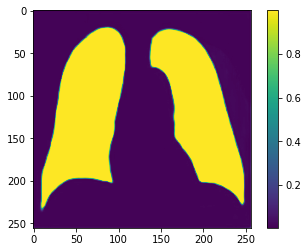

In [ ]:
plt.imshow(pred[0,...,0])
plt.colorbar()
plt.show()

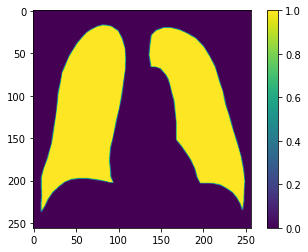

In [ ]:
plt.imshow(mask_array_training[img,...,0])
plt.colorbar()
plt.show()

In [ ]:
im_array_testing = im_array_testing[:,:,:,np.newaxis]
mask_array_testing = mask_array_testing[:,:,:,np.newaxis]

print(im_array_testing.shape)
add_layer = im_array_testing
print(add_layer.shape)
im_array_testing = np.concatenate([im_array_testing, add_layer], axis=3)
im_array_testing = np.concatenate([im_array_testing, add_layer], axis=3)
print(im_array_testing.shape)

In [ ]:
results = model.evaluate(im_array_testing, mask_array_testing)
print("test loss, test acc:", results)

123/123 [==============================] - 4s 29ms/step
test loss, test acc: [0.04995082224893376, 0.949981153011322]


# Manual model for skin lesion

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import sklearn

In [5]:
model = Sequential()
model.add(Conv2D(4, (3, 3), padding='same', input_shape=(256,256,3)))
model.add(Conv2D(8, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3),padding='same'))
model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(10))
model.add(Activation('softmax'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#'rmsprop',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 256, 256, 4)       112       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 8)       296       
_________________________________________________________________
activation_13 (Activation)   (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
activation_14 (Activation)   (None, 128, 128, 32)     

In [ ]:
@tf.function
def myLoss(y_true,y_pred):
  tf.compat.v1.enable_eager_execution()
  acum = 0
  for true, pred in zip(y_true,y_pred):
    acum += tf.keras.losses.binary_crossentropy(true,pred)
  return acum

In [ ]:
model = tf.keras.applications.VGG16(
    #include_top=True,
    weights=None,#"imagenet",
    #input_tensor=None,
    input_shape=(256,256,3),
    #pooling=None,
    classes=1
    #classifier_activation="softmax",
)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',#'adam',
              metrics=['accuracy'])

In [6]:
batch_size = 20

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator()
        #shear_range=0.2,
        # zoom_range=0.2,
        # rotation_range=10,
        # horizontal_flip=True,
        # vertical_flip=True,
        # fill_mode='nearest')

test_datagen = ImageDataGenerator()

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'drive/MyDrive/Split_org_size_data/training',  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'drive/MyDrive/Split_org_size_data/validation',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary')

Found 765 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [ ]:
class_weights = {0: 5., 1: 1.}
history = model.fit(
            train_generator,
            steps_per_epoch=765 // batch_size,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=134 // batch_size,
            class_weight = class_weights)
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
16/38 [===========>..................] - ETA: 6:10 - loss: 1.9988 - accuracy: 0.7937

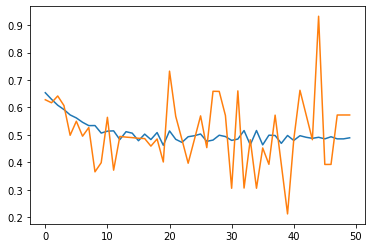

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
tf.compat.v1.disable_eager_execution()
tf.executing_eagerly()

False